# Estimate current camera coverage and how many we want for better coverage

In [1]:
import os
from glob import glob
import pandas as pd
import rioxarray as rxr
from shapely.geometry import shape, Polygon, LineString, MultiPolygon
from shapely import get_coordinates
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import numpy as np
import rasterio as rio
from tqdm import tqdm
import matplotlib

inputs_folder = '/Users/rdcrlrka/Research/Soo_locks/inputs'
cam_positions_file = os.path.join(inputs_folder, 'cams.txt')
ortho_files = sorted(glob(os.path.join(inputs_folder, '..', 'outputs', 'soo_locks_photogrammetry_20251001171000', 'orthoimages', '*.tiff')))
refdem_file = os.path.join(inputs_folder, 'lidar_DSM_filled_cropped.tif')

output_folder = os.path.join(inputs_folder, '..', 'add_cameras')
os.makedirs(output_folder, exist_ok=True)

# Load camera positions
cams = pd.read_csv(cam_positions_file, sep=' ', header=0)
cams['channel'] = [x.split('_')[1] for x in cams['img_name']]


## Helper functions

In [84]:
def calculate_image_footprint(raster_file):
    # create a mask of data coverage
    raster = rxr.open_rasterio(raster_file).isel(band=0)
    crs, transform = raster.rio.crs, raster.rio.transform()
    if 'DSM' in raster_file:
        raster = xr.where(raster!=-9999, raster, np.nan)
    else:
        raster = xr.where(raster > 0, raster, np.nan)
    mask = raster.notnull()

    # vectorize the mask
    shape_gen = (
        (shape(s), v) 
        for s, v in 
        rio.features.shapes(mask.values.astype(np.int8), transform=transform)
        ) 
    gdf = gpd.GeoDataFrame(dict(zip(["geometry", "mask"], zip(*shape_gen))), crs=crs)

    # use just the exterior of all polygons
    exteriors = [x.exterior for x in gdf['geometry']]
    exterior_polys = [Polygon(get_coordinates(x)) for x in exteriors]
    gdf['geometry'] = exterior_polys

    # add the camera "channel"
    gdf['channel'] = os.path.basename(raster_file).split('_')[0]
    
    # use the largest mask polygon
    gdf['area'] = [x.area for x in gdf.geometry]
    gdf = gdf.sort_values(by='area', ascending=False).reset_index(drop=True)
    gdf = gdf.iloc[0:3]
    gdf = gdf.loc[gdf['mask']==1].reset_index(drop=True)   

    # make sure there's only one remaining
    gdf = gpd.GeoDataFrame(gdf.iloc[0]).transpose()

    # buffer the polygon slightly to remove sharp divots
    gdf['geometry'] = [x.buffer(0.1, join_style=1) for x in gdf['geometry']]

    # recalculate area
    gdf['area'] = [x.area for x in gdf['geometry']]

    gdf = gdf.set_geometry('geometry', crs=crs)

    return gdf

def calculate_image_overlap(bounds_gdf, buffer=0.01):
    # Buffer to avoid slivers
    bounds_gdf['geometry'] = bounds_gdf['geometry'].buffer(buffer)
    
    overlaps = []
    for i in range(len(bounds_gdf)):
        poly1 = bounds_gdf.geometry.iloc[i]
        channel1 = bounds_gdf.channel.iloc[i]
        for j in range(i+1, len(bounds_gdf)):
            poly2 = bounds_gdf.geometry.iloc[j]
            channel2 = bounds_gdf.channel.iloc[j]
            intersection = poly1.intersection(poly2)
            if intersection.is_empty:
                continue
            overlaps.append({
                'channel_a': channel1,
                'channel_b': channel2,
                'overlap_area': intersection.area,
                'geometry': intersection
            })
    if overlaps:
        overlap_gdf = gpd.GeoDataFrame(overlaps, geometry='geometry', crs=bounds_gdf.crs)
    else:
        overlap_gdf = gpd.GeoDataFrame(columns=['channel_a','channel_b','overlap_area','geometry'], crs=bounds_gdf.crs)
    
    return overlap_gdf


def get_coords_between_cams(ch1, ch2):
    cam1 = cams.loc[cams['channel']==ch1]
    cam2 = cams.loc[cams['channel']==ch2]
    xcoord = np.nanmean([cam1['X'].values[0], cam2['X'].values[0]])
    ycoord = np.nanmean([cam1['Y'].values[0], cam2['Y'].values[0]])
    return (xcoord, ycoord)


def calculate_no_coverage(model_space_gdf, bounds_gdf, buffer=0.01):
    # Buffer footprints slightly to close slivers
    buffered_bounds = bounds_gdf.copy()
    buffered_bounds['geometry'] = buffered_bounds.geometry.buffer(buffer)
    
    # Union of all footprints
    total_coverage = unary_union(buffered_bounds.geometry)
    
    # Union of model space polygons
    model_union = unary_union(model_space_gdf.geometry)
    
    # Compute uncovered area
    no_coverage = model_union.difference(total_coverage)
    
    return no_coverage


def rotation_matrix_from_roll_pitch_yaw(roll, pitch, yaw):
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll),  np.cos(roll)]
    ])

    Ry = np.array([
        [ np.cos(pitch), 0, -np.sin(pitch)],
        [ 0, 1, 0],
        [ np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    Rz = np.array([
        [ np.cos(yaw), -np.sin(yaw), 0],
        [ np.sin(yaw),  np.cos(yaw), 0],
        [ 0, 0, 1]
    ])

    R = Rz @ Ry @ Rx
    return R

    
    
def create_new_footprint(
        camera_pos, 
        model_space, 
        roll_deg = 0,
        pitch_deg = 0,
        yaw_deg = 15, 
        fov_h_deg = 100, 
        fov_v_deg = 65, 
        ground_z = -8,
        trusses_gdf = None,
        truss_buffer = 0.2
        ):
    x0, y0, z0 = camera_pos

    # --- Calculate full footprint with no occlusions ---
    yaw, pitch, roll, fov_h, fov_v = map(np.deg2rad, [yaw_deg, pitch_deg, roll_deg, fov_h_deg, fov_v_deg])

    # Rays for 4 image corners (camera looks down -Z)
    dx = np.tan(fov_h / 2)
    dy = np.tan(fov_v / 2)
    corners_local = np.array([
        [ dx,  dy, -1],  # UR
        [-dx,  dy, -1],  # UL
        [-dx, -dy, -1],  # LL
        [ dx, -dy, -1],  # LR
    ])
    corners_local /= np.linalg.norm(corners_local, axis=1)[:, None]

    # Rotate rays
    R = rotation_matrix_from_roll_pitch_yaw(roll, pitch, yaw)
    dirs = corners_local @ R.T

    # Intersect each ray with ground plane z=ground_z
    t = (ground_z - z0) / dirs[:, 2]
    xy = np.column_stack((x0 + t * dirs[:, 0], y0 + t * dirs[:, 1]))
    if len(xy) < 3:
        print('No valid footprint')
        return None

    footprint = Polygon(xy)

    # Crop to model space
    footprint = footprint.intersection(model_space['geometry'].values[0])

    # --- Check for occlusion by ceiling trusses ---
    if trusses_gdf is None or trusses_gdf.empty:
        return footprint

    # Initialize visible footprint
    visible_footprint = footprint

    # Iterate over trusses individually
    for _, row in trusses_gdf.iterrows():
        geom = row.geometry
        # Only consider trusses between camera and ground
        if geom.has_z:
            z_vals = np.array(geom.exterior.coords)[:, 2]
            if np.nanmin(z_vals) >= z0 or np.nanmax(z_vals) <= ground_z:
                continue
            coords_2d = np.array(geom.exterior.coords)[:, :2]
            truss_2d = Polygon(coords_2d).buffer(truss_buffer)
        else:
            truss_2d = geom.buffer(truss_buffer)

        # Subtract only if it intersects the current visible footprint
        if visible_footprint.intersects(truss_2d):
            visible_footprint = visible_footprint.difference(truss_2d)

        # If footprint is fully blocked, return empty Polygon
        if visible_footprint.is_empty:
            return Polygon()

    return visible_footprint


def calculate_specs_from_new_coords(
        new_coords: np.array = None, 
        new_rolls: np.array = None, 
        new_pitches: np.array = None, 
        new_yaws: np.array = None, 
        cams: pd.DataFrame = None, 
        bounds: gpd.GeoDataFrame = None, 
        model_space: gpd.GeoDataFrame = None, 
        fov_h: float = 120, 
        fov_v: float = 65,
        trusses_gdf: gpd.GeoDataFrame = None
        ):
    
    # --- Create new cameras dataframe ---
    new_channels = np.arange(len(new_coords)) + 1 + len(cams)
    new_channels_string = [f"ch{x}" if x >=10 else f"ch0{x}" for x in new_channels]

    cams_new = pd.DataFrame({
        'img_name': ['None']*len(new_coords),
        'X': new_coords[:,0],
        'Y': new_coords[:,1],
        'Z': new_coords[:,2],
        'X_std': [0.1]*len(new_coords),
        'Y_std': [0.1]*len(new_coords),
        'Z_std': [0.1]*len(new_coords),
        'channel': new_channels_string
    })
    
    # Combine original + new cameras
    cams_new_full = pd.concat([cams, cams_new]).reset_index(drop=True)
    n_total = len(cams_new_full)
    n_existing = len(cams)
    n_new = len(cams_new)
    
    # --- Ensure rotation arrays are correctly sized ---
    if new_rolls is None:
        new_rolls = np.zeros(n_new)
    if new_pitches is None:
        new_pitches = np.zeros(n_new)
    if new_yaws is None:
        new_yaws = 15*np.ones(n_new)
        
    # Full arrays: existing cameras assumed nadir (0 roll/pitch) + yaw=15 deg
    rolls_full = np.concatenate([np.zeros(n_existing), new_rolls])
    pitches_full = np.concatenate([np.zeros(n_existing), new_pitches])
    yaws_full = np.concatenate([15*np.ones(n_existing), new_yaws])
    
    # --- Calculate footprints for all cameras ---
    bounds_new_list = []
    for i in range(n_total):
        cam_pos = cams_new_full[['X','Y','Z']].iloc[i].values
        roll, pitch, yaw = rolls_full[i], pitches_full[i], yaws_full[i]
        footprint = create_new_footprint(
            camera_pos=cam_pos,
            model_space=model_space,
            roll_deg=roll,
            pitch_deg=pitch,
            yaw_deg=yaw,
            fov_h_deg=fov_h,
            fov_v_deg=fov_v,
            trusses_gdf=trusses_gdf
        )
        bounds_new_list.append(gpd.GeoDataFrame({
            'geometry': [footprint],
            'channel': [cams_new_full['channel'].iloc[i]]
        }))
    
    bounds_new_gdf = pd.concat(bounds_new_list[n_existing:]).reset_index(drop=True)
    bounds_new_gdf['geometry'] = bounds_new_gdf['geometry']
    bounds_new_full_gdf = pd.concat([bounds_gdf, bounds_new_gdf]).reset_index(drop=True)
    bounds_new_full_gdf['geometry'] = bounds_new_full_gdf['geometry']
    
    # recalculate overlap 
    overlap_new_gdf = calculate_image_overlap(bounds_new_full_gdf) 

    # identify model space with no coverage 
    no_coverage_new_full = calculate_no_coverage(model_space, bounds_new_full_gdf) 
    print('No coverage area = ', np.round(no_coverage_new_full.area,1), 'm^2') 
    
    return cams_new, cams_new_full, bounds_new_gdf, bounds_new_full_gdf, overlap_new_gdf, no_coverage_new_full


def create_distortion_map(
    cams_gdf,
    footprints_gdf,
    yaw_series,
    pitch_series,
    roll_series,
    fov_h_deg=120,
    fov_v_deg=65,
    dx=0.05,
    dy=0.05,
    model_floor_z=-8,
    model_space=None
):
    """
    Computes a raster of relative distortion based on angular distance from each camera's optical center.
    Overlapping images are merged using the minimum distortion at each pixel.
    """
    # Raster bounds
    x_min, y_min, x_max, y_max = footprints_gdf.total_bounds
    xs = np.arange(x_min, x_max + dx, dx)
    ys = np.arange(y_max, y_min - dy, -dy)  # descending for raster origin
    shape = (len(ys), len(xs))
    
    # Initialize raster
    out_raster = np.full(shape, np.nan, dtype=float)
    yy, xx = np.meshgrid(ys, xs, indexing='ij')
    
    # Lowest distortion at half the FOV angles
    half_h = np.deg2rad(fov_h_deg/2)
    half_v = np.deg2rad(fov_v_deg/2)
    
    # Loop over cameras
    for i, row in footprints_gdf.iterrows():
        cam = cams_gdf.iloc[i]
        footprint = row.geometry
        roll, pitch, yaw = map(np.deg2rad, [roll_series[i], pitch_series[i], yaw_series[i]])
        Rcw = rotation_matrix_from_roll_pitch_yaw(roll, pitch, yaw)
        Rwc = Rcw.T
        cam_pos = cam[['X','Y','Z']].values.astype(float)
        
        # Rasterize footprint
        transform = rio.transform.from_origin(x_min, y_max, dx, dy)
        mask = rio.features.rasterize(
            [(footprint,1)], 
            out_shape=shape, 
            transform=transform,
            fill=0, 
            all_touched=True
            ).astype(bool)
        if not mask.any():
            print('Footprint not valid, skipping.')
            continue
        
        # World coordinates of raster pixels in footprint
        px = xx[mask]
        py = yy[mask]
        pz = np.full_like(px, model_floor_z)
        points_xyz = np.vstack([px, py, pz]).T
        
        # Vector from camera to points
        v = points_xyz - cam_pos
        v_cam = (Rwc @ v.T).T  # world -> camera frame
        
        # Keep only points in front of camera
        visible = visible = v_cam[:,2] < 0
        if np.sum(visible) == 0:
            continue
        v_cam_vis = v_cam[visible]
        mask_indices = np.flatnonzero(mask)[visible]
        
        # Calculate distance from optical center
        alpha = np.arctan2(v_cam_vis[:,0], v_cam_vis[:,2])
        beta  = np.arctan2(v_cam_vis[:,1], v_cam_vis[:,2])
        norm_radius = np.sqrt((alpha/half_h)**2 + (beta/half_v)**2)

        # Convert to distortion: low at center, high at edges
        distortion = 1 - norm_radius
        
        # Merge into output raster (min distortion)
        current_vals = out_raster.flat[mask_indices]
        current_vals = np.where(np.isnan(current_vals), distortion, np.minimum(current_vals, distortion))
        out_raster.flat[mask_indices] = current_vals
    
    # Construct xarray DataArray
    distortion_map = xr.DataArray(
        out_raster, 
        coords={'y': ys, 'x': xs}, 
        dims=('y','x'), 
        name='distortion'
        )
    
    # Clip to model space
    distortion_map.rio.write_crs("EPSG:32619", inplace=True)
    distortion_map = distortion_map.rio.clip(model_space['geometry'])
    
    return distortion_map

    
def plot_model_coverage(axis, model_space, bounds, overlap, cam_positions, no_coverage,
                        bounds_color='#7570b3', overlap_color='#7570b3', missing_color='#d95f02', new_cam_color='#e7298a'):
    # model space
    model_space.plot(ax=axis, edgecolor='k', facecolor='None', linewidth=2)
    # image footprints
    bounds.plot(ax=axis, edgecolor=bounds_color, linewidth=2, linestyle='--', facecolor='None', legend=False)
    # image overlap
    overlap.plot(ax=axis, color=overlap_color, alpha=0.5, legend=False)
    # missing model coverage
    no_coverage_gdf = gpd.GeoDataFrame(geometry=[no_coverage], crs="EPSG:32619")
    no_coverage_gdf.plot(ax=axis, edgecolor='None', facecolor=missing_color, alpha=0.5, legend=False)
    # current and NEW camera positions
    cam_positions_current = cam_positions.iloc[0:16]
    axis.plot(cam_positions_current['X'].values, cam_positions_current['Y'].values, '*k', markersize=8, label='Cameras')
    cam_positions_new = cam_positions.iloc[16:]
    axis.plot(cam_positions_new['X'].values, cam_positions_new['Y'].values, '*', 
              markerfacecolor=new_cam_color, markeredgecolor='w', linewidth=0.5, markersize=12, label='NEW cameras')
    # dummy points for legend
    xmin, xmax = axis.get_xlim()
    ymin, ymax = axis.get_ylim()
    axis.plot(1e3, 1e3, '-k', linewidth=2,label='Model space')
    axis.plot(1e3, 1e3, '--', linewidth=2, color=bounds_color, label='Image footprint')
    axis.plot(1e3, 1e3, 's', markerfacecolor=overlap_color, alpha=0.5, markeredgecolor='None', markersize=10, label='Image overlap')
    axis.plot(1e3, 1e3, 's', markerfacecolor=missing_color, alpha=0.5, markeredgecolor='None', markersize=10, label='No coverage')
    axis.set_xlim(xmin, xmax)
    axis.set_ylim(ymin, ymax)
    axis.set_xlabel('X [meters]')
    axis.set_ylabel('Y [meters]')
    return


def plot_vertical_view(axis, trusses_gdf, cams = None, cams_new = None, bounds = None, bounds_new = None,
                       bounds_color='#7570b3', new_cam_color='#e7298a'):
    # trusses
    for i,row in trusses_gdf.iterrows():
        truss_y = np.array([coord[1] for coord in row['geometry'].exterior.coords])
        truss_ymean = np.nanmean(truss_y)
        truss_z = np.array([coord[2] for coord in row['geometry'].exterior.coords])
        truss_zmin = np.nanmin(truss_z)
        axis.plot([truss_ymean, truss_ymean], [truss_zmin, -3], '-k')
        if i==6:
            axis.plot([truss_ymean, truss_ymean], [truss_zmin, -3], '-r')

    # current camera footprints
    def plot_cam_footprints(b_gdf, c_gdf):
        for i,row in b_gdf.iterrows():
            bound = row['geometry']
            if type(bound)==MultiPolygon:
                bound_y = np.array([])
                for geom in bound.geoms:
                    _, geom_y = geom.exterior.coords.xy
                    bound_y = np.append(bound_y, geom_y)
            else:
                _, bound_y = bound.exterior.coords.xy
            bound_ymin, bound_ymax = np.min(bound_y), np.max(bound_y)
            cam_y, cam_z = c_gdf.iloc[i][['Y', 'Z']].values
            bound_poly = matplotlib.patches.Polygon(
                np.array([[bound_ymin, -8],[bound_ymax, -8], [cam_y, cam_z], [bound_ymin, -8]]),
                facecolor=bounds_color, alpha=0.3, edgecolor='None'
            )
            axis.add_patch(bound_poly)
    plot_cam_footprints(bounds, cams)
    if cams_new is not None:
        plot_cam_footprints(bounds_new, cams_new)

    # current camera positions
    for i,row in cams.iterrows():
        axis.plot(row['Y'], row['Z'], '*k', markersize=10)

    # new camera positions
    if cams_new is not None:
        for i,row in cams_new.iterrows():
            axis.plot(row['Y'], row['Z'], '*', color=new_cam_color, markersize=10)
    
    # ceiling
    axis.plot([0,70], [-3,-3], '-k')
    # model ground-ish
    axis.plot([0,70], [-8,-8], '-k')
    # add some text labels
    axis.text(70,-7.8, '~Model', horizontalalignment='right', fontsize=12, color='k')
    axis.text(70,-5.4, 'Trusses', horizontalalignment='right', fontsize=12)
    axis.text(70,-3.5, 'Ceiling', horizontalalignment='right', fontsize=12)
    axis.set_xlabel('Y [meters]')
    axis.set_ylabel('Z [meters]')

    return


def save_specs_los(bounds_new, cams_new, out_file, fov_h=120, fov_v=65):
    # Estimate FOV
    rotation = -13
    yaw = 360 + rotation
    cam_height = float(cams['Z'].mean()) + 8
    specs_list = []
    for i,_ in bounds_new.iterrows():
        cam = cams_new.iloc[i]
        # compile in dataframe
        df = pd.DataFrame({
            'new_cam_number': i+1,
            'X': cam['X'],
            'Y': cam['Y'],
            'Z': cam_height,
            'FOV_vertical': fov_v,
            'FOV_horizontal': fov_h,
            'roll': 0,
            'pitch': 0,
            'yaw': yaw
        }, index=[i])
        specs_list += [df]

    specs_df = pd.concat(specs_list)
    specs_df = specs_df.round(2)

    # save
    specs_df.to_csv(out_file, header=True, index=False)
    print("New camera specs saved to file:", out_file)
    return



## Calculate current camera coverage

In [3]:
print('Creating polygon of model space')
model_space_gdf = calculate_image_footprint(refdem_file)

print('Calculating image footprints')
gdf_list = []
for ortho_file in tqdm(ortho_files):
    gdf = calculate_image_footprint(ortho_file)
    gdf_list += [gdf]
bounds_df = pd.concat(gdf_list).reset_index(drop=True)
bounds_gdf = gpd.GeoDataFrame(bounds_df, geometry=bounds_df['geometry'], crs=gdf.crs)

print('Calculating overlap areas')
overlap_gdf = calculate_image_overlap(bounds_gdf)

print('Calculating area with no coverage')
no_coverage = calculate_no_coverage(model_space_gdf, bounds_gdf)
print('Done')

Creating polygon of model space
Calculating image footprints


100%|██████████| 16/16 [00:37<00:00,  2.36s/it]

Calculating overlap areas
Calculating area with no coverage
Done


## Model the camera FOV

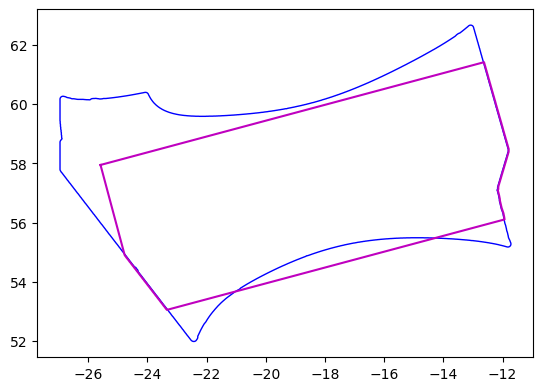

In [4]:
# Cropped to where the image isn't super warped
fov_h = 120
fov_v = 65

# Test for one camera to assess FOV values
bounds = bounds_gdf.loc[bounds_gdf['channel']=='ch16']
cam = cams.loc[cams['channel']=='ch16']
cam_poly = create_new_footprint(
    cam[['X', 'Y', 'Z']].values[0],
    model_space_gdf,
    roll_deg = 0,
    pitch_deg = 0,
    yaw_deg = 15,
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    ground_z = -8
    )

fig, ax = plt.subplots()
ax.plot(cam_poly.exterior.coords.xy[0], cam_poly.exterior.coords.xy[1], '-m')
bounds.plot(ax=ax, facecolor='None', edgecolor='b')
plt.show()

## Model the ceiling trusses

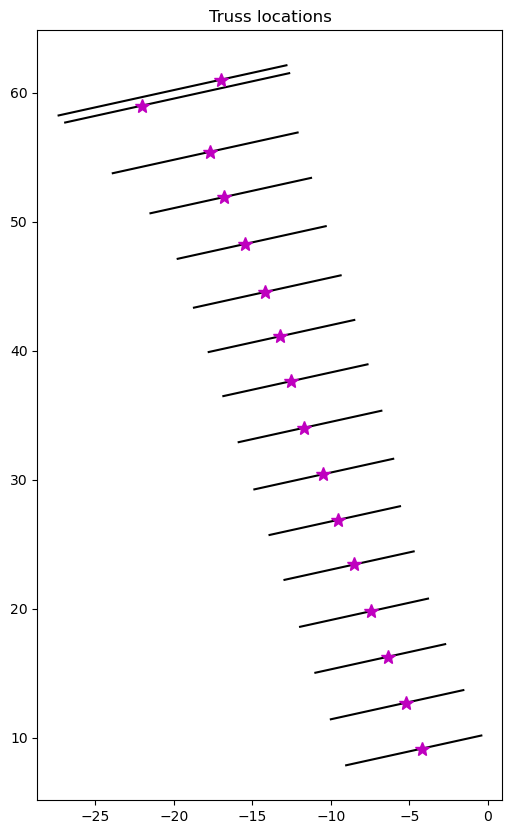

,geometry
0,"POLYGON Z ((-26.921 57.681 -4.8, -12.652 61.50..."
1,"POLYGON Z ((-27.339 58.23 -4.81, -12.827 62.11..."
2,"POLYGON Z ((-9.023 7.859 -5.62, -0.413 10.166 ..."
3,"POLYGON Z ((-9.999 11.424 -5.65, -1.559 13.685..."
4,"POLYGON Z ((-10.984 15.032 -5.63, -2.717 17.24..."
5,"POLYGON Z ((-11.959 18.594 -5.64, -3.81 20.777..."
6,"POLYGON Z ((-12.951 22.231 -5.77, -4.723 24.43..."
7,"POLYGON Z ((-13.903 25.711 -4.77, -5.594 27.93..."
8,"POLYGON Z ((-14.87 29.245 -4.78, -6.026 31.615..."
9,"POLYGON Z ((-15.869 32.905 -4.79, -6.781 35.34..."


In [5]:
# Load the rafter heights from Dom
raster_heights_file = os.path.join(inputs_folder, 'rafter-heights(Rafter Z Values).csv')
rh = pd.read_csv(raster_heights_file)

# skip the northern trusses for now (not sure on the angles)
# truss_heights = rh.iloc[2:].reset_index(drop=True)
truss_heights = rh.copy()

# Get the center x and y coordinates from camera locations
x_coords, y_coords = [],[]
for i,row in truss_heights.iterrows():
    if i==0:
        x,y = -22, 59
    elif i==1:
        x,y = -17, 61
    else:
        ch1,ch2 = row['Label'].split('-')
        x,y = get_coords_between_cams(ch1, ch2)
    x_coords += [x]
    y_coords += [y]
truss_heights['xc'] = x_coords
truss_heights['yc'] = y_coords

fig, ax = plt.subplots(figsize=(6,10))

# Create LineString of bottom truss extent - extend 20 m perpendicular to camera yaw
truss_angle = 15
ext = 20
extents = []
for i,row in truss_heights.iterrows():
    yleft = row['yc'] - (ext * np.sin(np.deg2rad(truss_angle)))
    xleft = row['xc'] - (ext * np.cos(np.deg2rad(truss_angle)))
    yright = row['yc'] + (ext * np.sin(np.deg2rad(truss_angle)))
    xright = row['xc'] + (ext * np.cos(np.deg2rad(truss_angle)))
    extent = LineString([(xleft,yleft), (xright, yright)])
    # crop to model space
    extent = extent.intersection(model_space_gdf['geometry'].values[0])
    extents += [extent]
    # plot
    ax.plot(extent.coords.xy[0], extent.coords.xy[1], '-k')
    ax.plot(row['xc'], row['yc'], '*m', markersize=10)

ax.set_title('Truss locations')
plt.show()

truss_heights['extent'] = extents

# Now, create 3D polygons by extending to the ceiling
ceiling_height = 10
geoms = []
for i,row in truss_heights.iterrows():
    x1, x2 = row['extent'].coords.xy[0]
    y1, y2 = row['extent'].coords.xy[1]
    z1 = row['Z-Value - 15cm']
    z2 = ceiling_height
    geoms += [Polygon([
        [x1, y1, z1],
        [x2, y2, z1],
        [x2, y2, z2],
        [x1, y1, z2],
        [x1, y1, z1]
    ])]

# Convert to geodataframe
trusses_gdf = gpd.GeoDataFrame(geometry=geoms, crs="EPSG:32619")
trusses_gdf

## Plot current model coverage

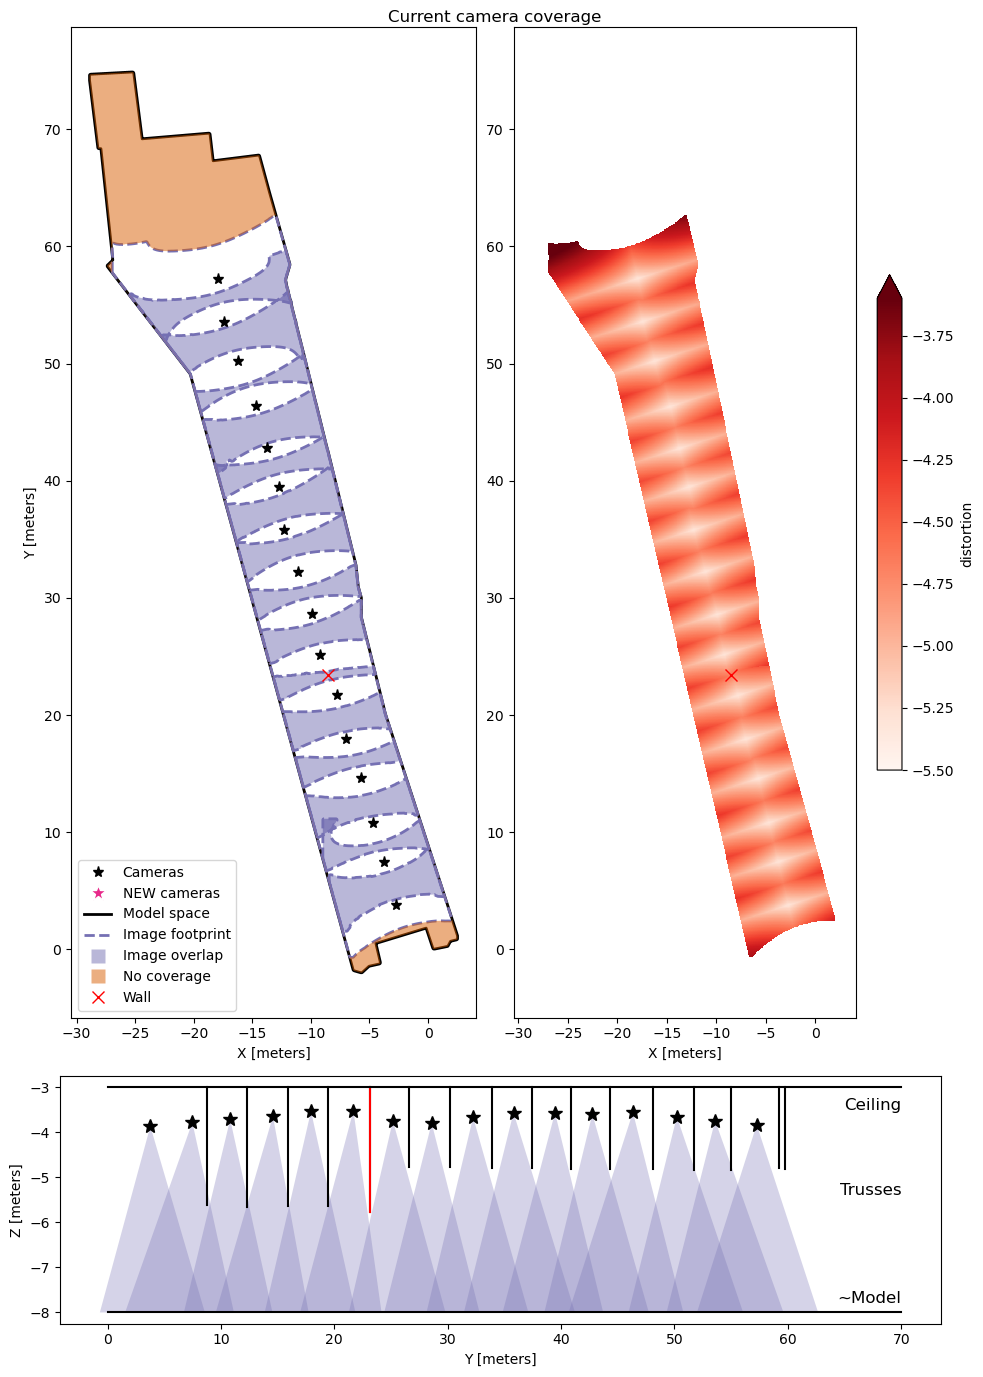

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/current_coverage.png
New camera specs saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/current_coverage_specs.csv


In [55]:
# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
plot_model_coverage(ax[0], model_space_gdf, bounds_gdf, overlap_gdf, cams, no_coverage)

# plot vertical view
plot_vertical_view(ax[2], trusses_gdf, cams, cams_new=None, bounds = bounds_gdf, bounds_new = None)
# plot relative distortion
distortion_map = create_distortion_map(
    cams_gdf = cams,
    footprints_gdf = bounds_gdf,
    yaw_series = 15 * np.ones(len(cams)),
    pitch_series = np.zeros(len(cams)),
    roll_series = np.zeros(len(cams)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=-5.5, vmax=-3.6, cbar_kwargs={'shrink': 0.5})
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
# plot the wall location
xcoord, ycoord = get_coords_between_cams('ch06', 'ch07')
for axis in ax[0:2]:
    axis.plot(xcoord, ycoord, 'xr', markersize=8, linewidth=2, label='Wall')
ax[0].legend(loc='lower left')

fig.suptitle('Current camera coverage')
fig.tight_layout()
plt.show()

# Save figure
fig_file = os.path.join(output_folder, 'current_coverage.png')
fig.savefig(fig_file, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_file)

# Save new specs
out_file = os.path.join(output_folder, 'current_coverage_specs.csv')
save_specs_los(bounds_gdf, cams, out_file, fov_h=fov_h, fov_v=fov_v)

## Add 8 more NADIR cameras at truss height

/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  125.9 m^2


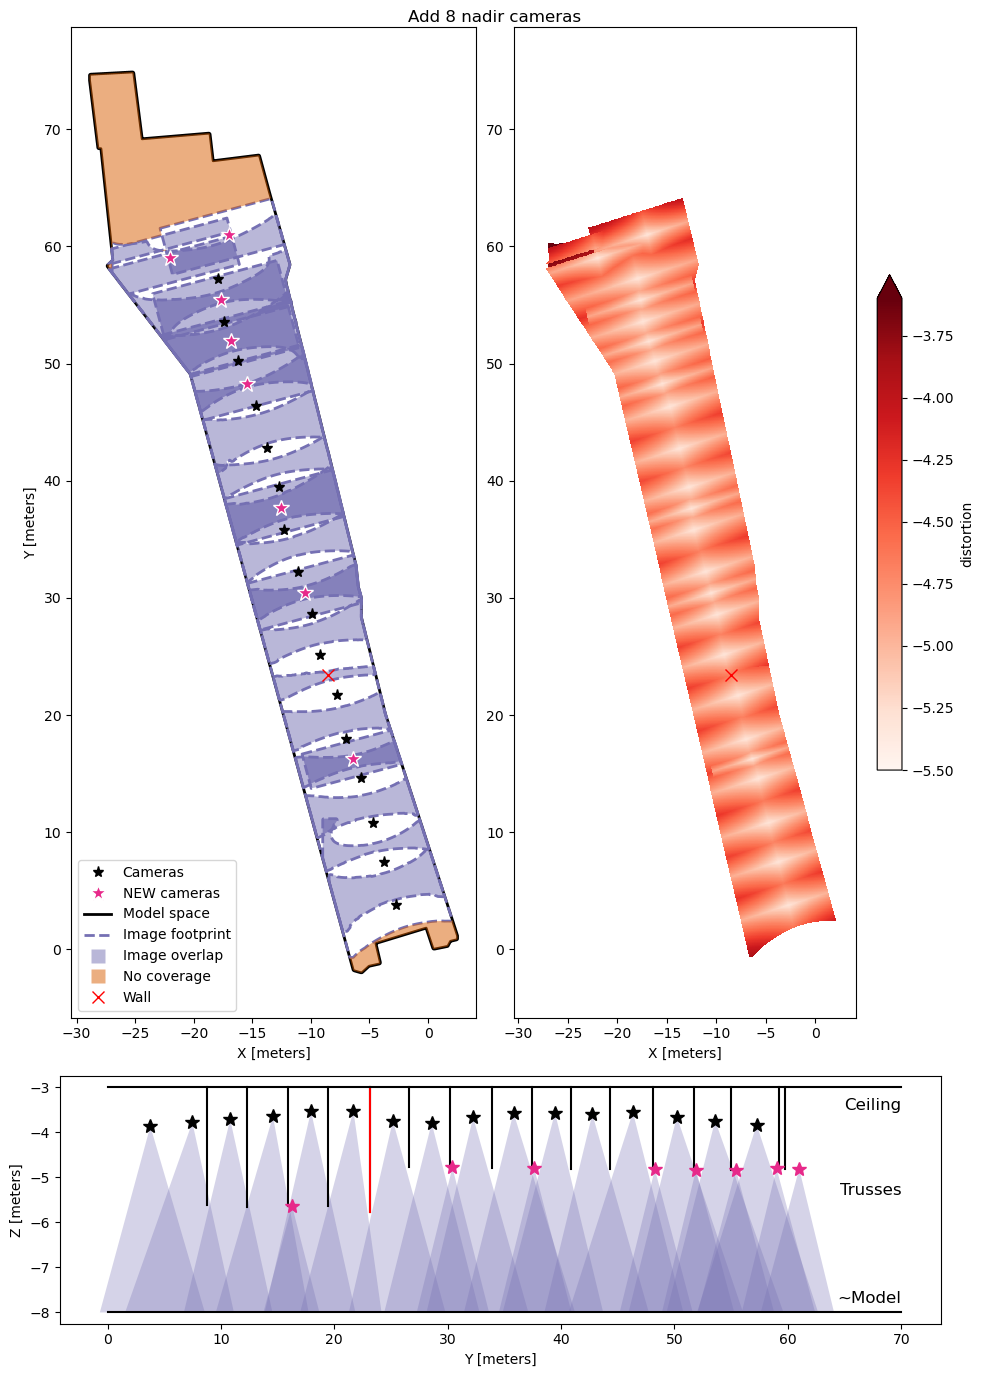

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_8_nadir_cameras.png
New camera specs saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_8_nadir_cams_specs.csv


In [90]:
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch04', 'ch05')), rh.loc[rh['Label']=='ch04-ch05', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch08', 'ch09')), rh.loc[rh['Label']=='ch08-ch09', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch10', 'ch11')), rh.loc[rh['Label']=='ch10-ch11', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch13', 'ch14')), rh.loc[rh['Label']=='ch13-ch14', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch14', 'ch15')), rh.loc[rh['Label']=='ch14-ch15', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch15', 'ch16')), rh.loc[rh['Label']=='ch15-ch16', 'Z-Value - 15cm'].values[0])
])

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = calculate_specs_from_new_coords(
     new_coords = new_coords,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

# plot vertical view
plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

# plot relative distortion
distortion_map = create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    pitch_series = np.zeros(len(cams_new_full)),
    roll_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=-5.5, vmax=-3.6, cbar_kwargs={'shrink': 0.5})
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
# plot the wall location
xcoord, ycoord = get_coords_between_cams('ch06', 'ch07')
for axis in ax[0:2]:
    axis.plot(xcoord, ycoord, 'xr', markersize=8, linewidth=2, label='Wall')
ax[0].legend(loc='lower left')

fig.suptitle('Add 8 nadir cameras')
fig.tight_layout()
plt.show()

# Save figure
fig_file = os.path.join(output_folder, 'add_8_nadir_cameras.png')
fig.savefig(fig_file, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_file)

# Save new specs
out_file = os.path.join(output_folder, 'add_8_nadir_cams_specs.csv')
save_specs_los(bounds_new_gdf, cams_new, out_file, fov_h=fov_h, fov_v=fov_v)

## Add 8 cameras with 45 degree angles

/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  114.8 m^2


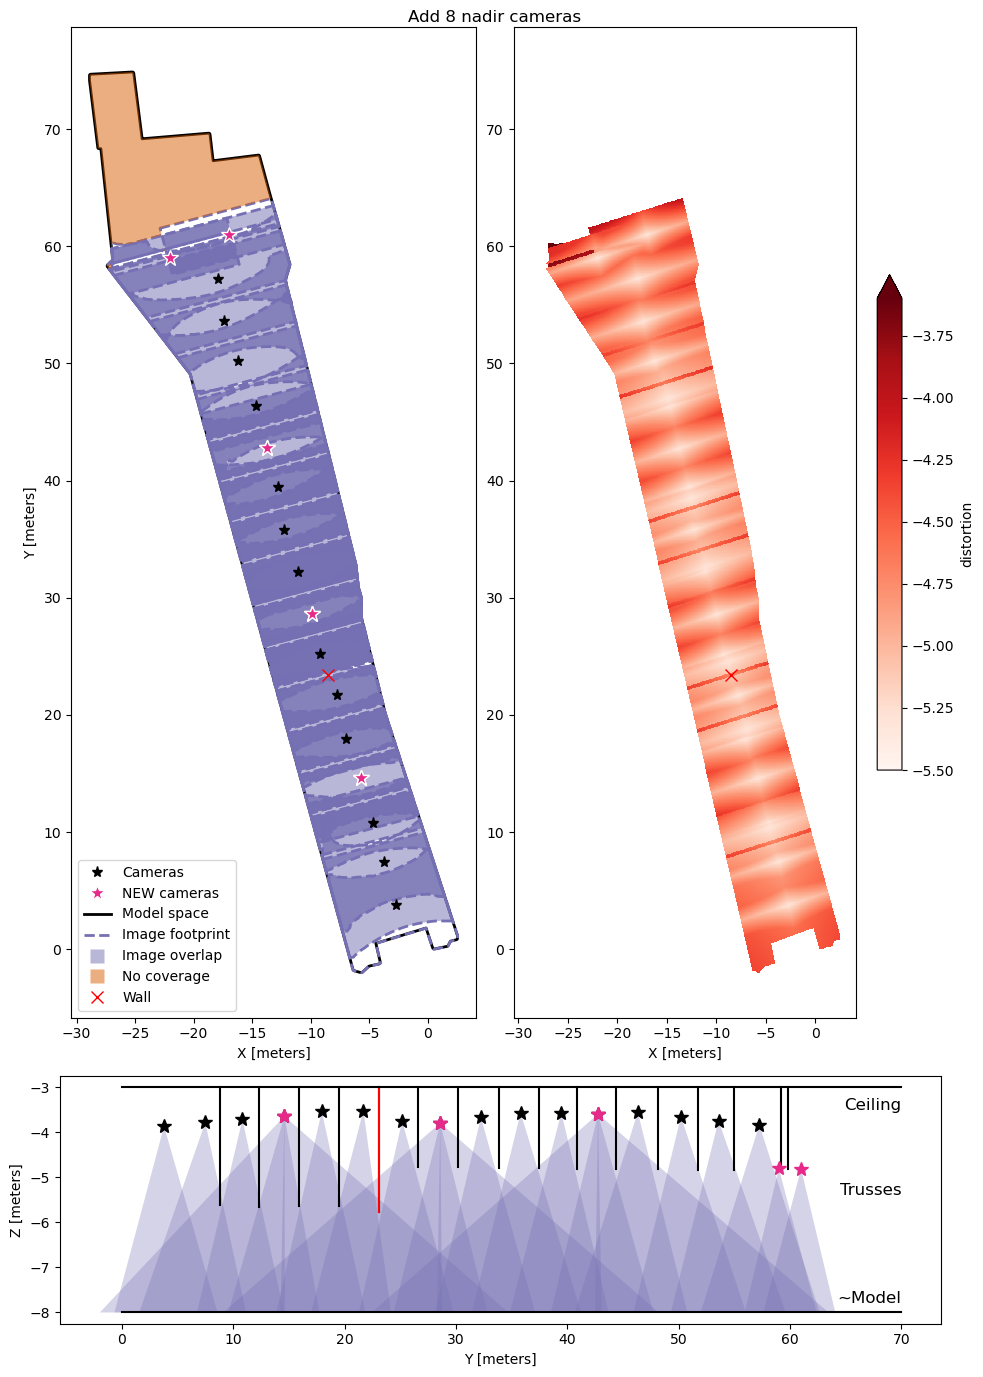

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_8_angled_cameras.png
New camera specs saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_8_angled_cams_specs.csv


In [96]:
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0]),
    cams.loc[cams['channel']=='ch04', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch04', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch08', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch08', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch12', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch12', ['X', 'Y', 'Z']].values[0],
])

new_rolls = np.concatenate([
    np.zeros(2),                            # northern-most cams
    45* np.array([-1, 1, -1, 1, -1, 1])     # rest of the cams
])

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = calculate_specs_from_new_coords(
     new_coords = new_coords,
     new_rolls = new_rolls,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Calculate map of relative distortion
distortion_map = create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    roll_series = np.concatenate([np.zeros(len(cams)), new_rolls]), 
    pitch_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

# plot vertical view
plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

# plot relative distortion
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=-5.5, vmax=-3.6, cbar_kwargs={'shrink': 0.5})
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
# plot the wall location
xcoord, ycoord = get_coords_between_cams('ch06', 'ch07')
for axis in ax[0:2]:
    axis.plot(xcoord, ycoord, 'xr', markersize=8, linewidth=2, label='Wall')
ax[0].legend(loc='lower left')

fig.suptitle('Add 8 nadir cameras')
fig.tight_layout()
plt.show()

# Save figure
fig_file = os.path.join(output_folder, 'add_8_angled_cameras.png')
fig.savefig(fig_file, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_file)

# Save new specs
out_file = os.path.join(output_folder, 'add_8_angled_cams_specs.csv')
save_specs_los(bounds_new_gdf, cams_new, out_file, fov_h=fov_h, fov_v=fov_v)

## Add 16 more NADIR cameras at truss height

/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  125.9 m^2


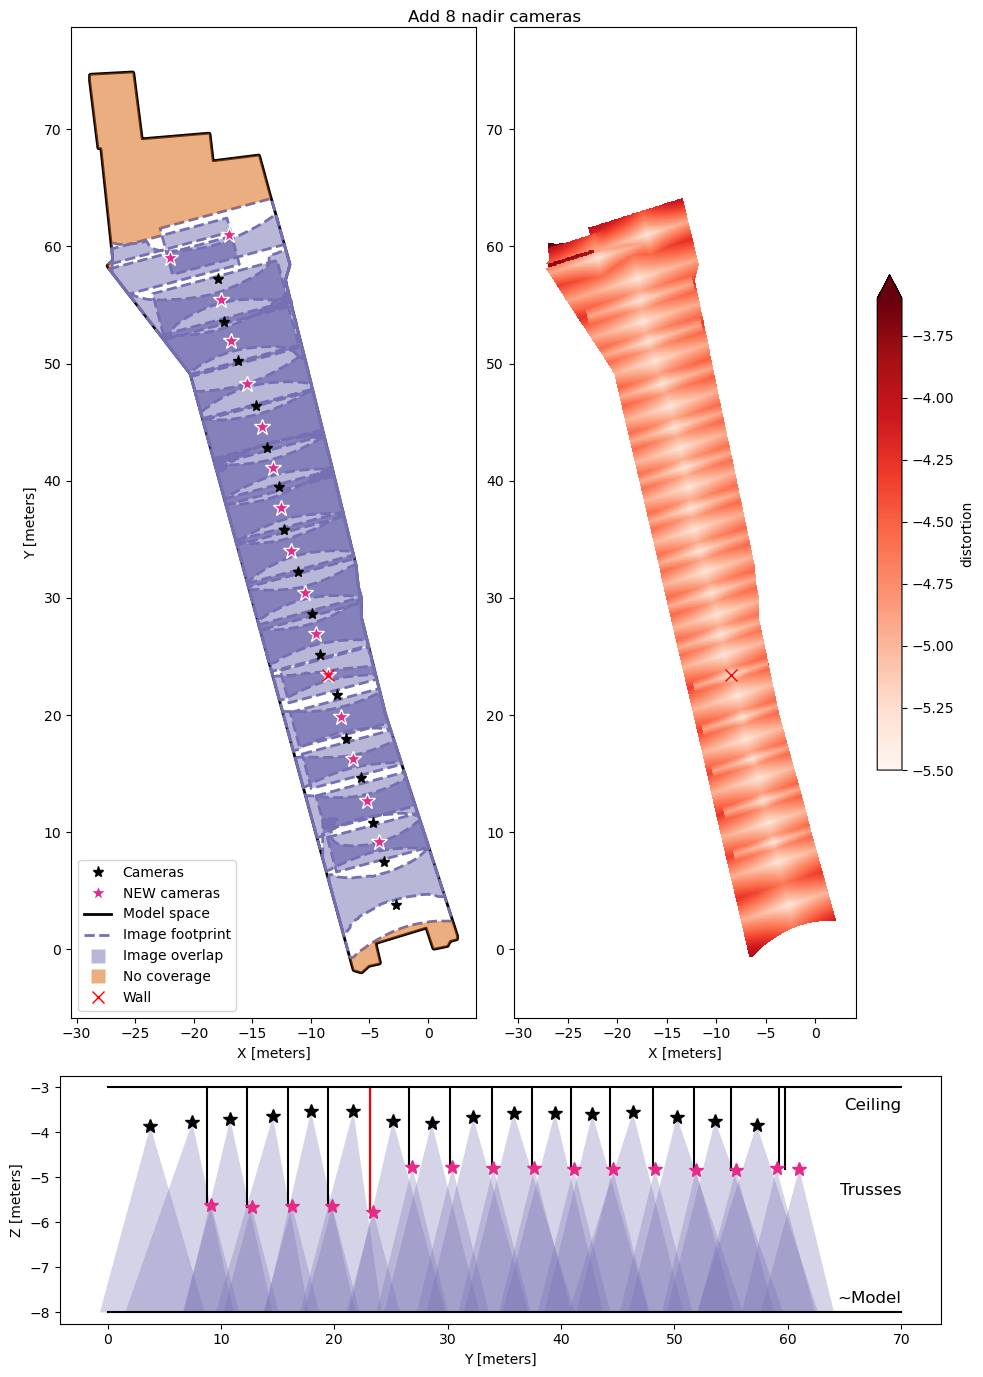

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_16_nadir_cameras.png
New camera specs saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_16_nadir_cams_specs.csv


In [97]:
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch02', 'ch03')), rh.loc[rh['Label']=='ch02-ch03', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch03', 'ch04')), rh.loc[rh['Label']=='ch03-ch04', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch04', 'ch05')), rh.loc[rh['Label']=='ch04-ch05', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch05', 'ch06')), rh.loc[rh['Label']=='ch05-ch06', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch06', 'ch07')), rh.loc[rh['Label']=='ch06-ch07', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch07', 'ch08')), rh.loc[rh['Label']=='ch07-ch08', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch08', 'ch09')), rh.loc[rh['Label']=='ch08-ch09', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch09', 'ch10')), rh.loc[rh['Label']=='ch09-ch10', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch10', 'ch11')), rh.loc[rh['Label']=='ch10-ch11', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch11', 'ch12')), rh.loc[rh['Label']=='ch11-ch12', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch12', 'ch13')), rh.loc[rh['Label']=='ch12-ch13', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch13', 'ch14')), rh.loc[rh['Label']=='ch13-ch14', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch14', 'ch15')), rh.loc[rh['Label']=='ch14-ch15', 'Z-Value - 15cm'].values[0]),
    np.append(np.array(get_coords_between_cams('ch15', 'ch16')), rh.loc[rh['Label']=='ch15-ch16', 'Z-Value - 15cm'].values[0])
])

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = calculate_specs_from_new_coords(
     new_coords = new_coords,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

# plot vertical view
plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

# plot relative distortion
distortion_map = create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    pitch_series = np.zeros(len(cams_new_full)),
    roll_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=-5.5, vmax=-3.6, cbar_kwargs={'shrink': 0.5})
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
# plot the wall location
xcoord, ycoord = get_coords_between_cams('ch06', 'ch07')
for axis in ax[0:2]:
    axis.plot(xcoord, ycoord, 'xr', markersize=8, linewidth=2, label='Wall')
ax[0].legend(loc='lower left')

fig.suptitle('Add 8 nadir cameras')
fig.tight_layout()
plt.show()

# Save figure
fig_file = os.path.join(output_folder, 'add_16_nadir_cameras.png')
fig.savefig(fig_file, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_file)

# Save new specs
out_file = os.path.join(output_folder, 'add_16_nadir_cams_specs.csv')
save_specs_los(bounds_new_gdf, cams_new, out_file, fov_h=fov_h, fov_v=fov_v)

## Add 16 more cameras at 45 degree angles

/Users/rdcrlrka/.local/share/mamba/envs/soo_locks/lib/python3.12/site-packages/geopandas/array.py:1755: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 19N (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


No coverage area =  28.4 m^2


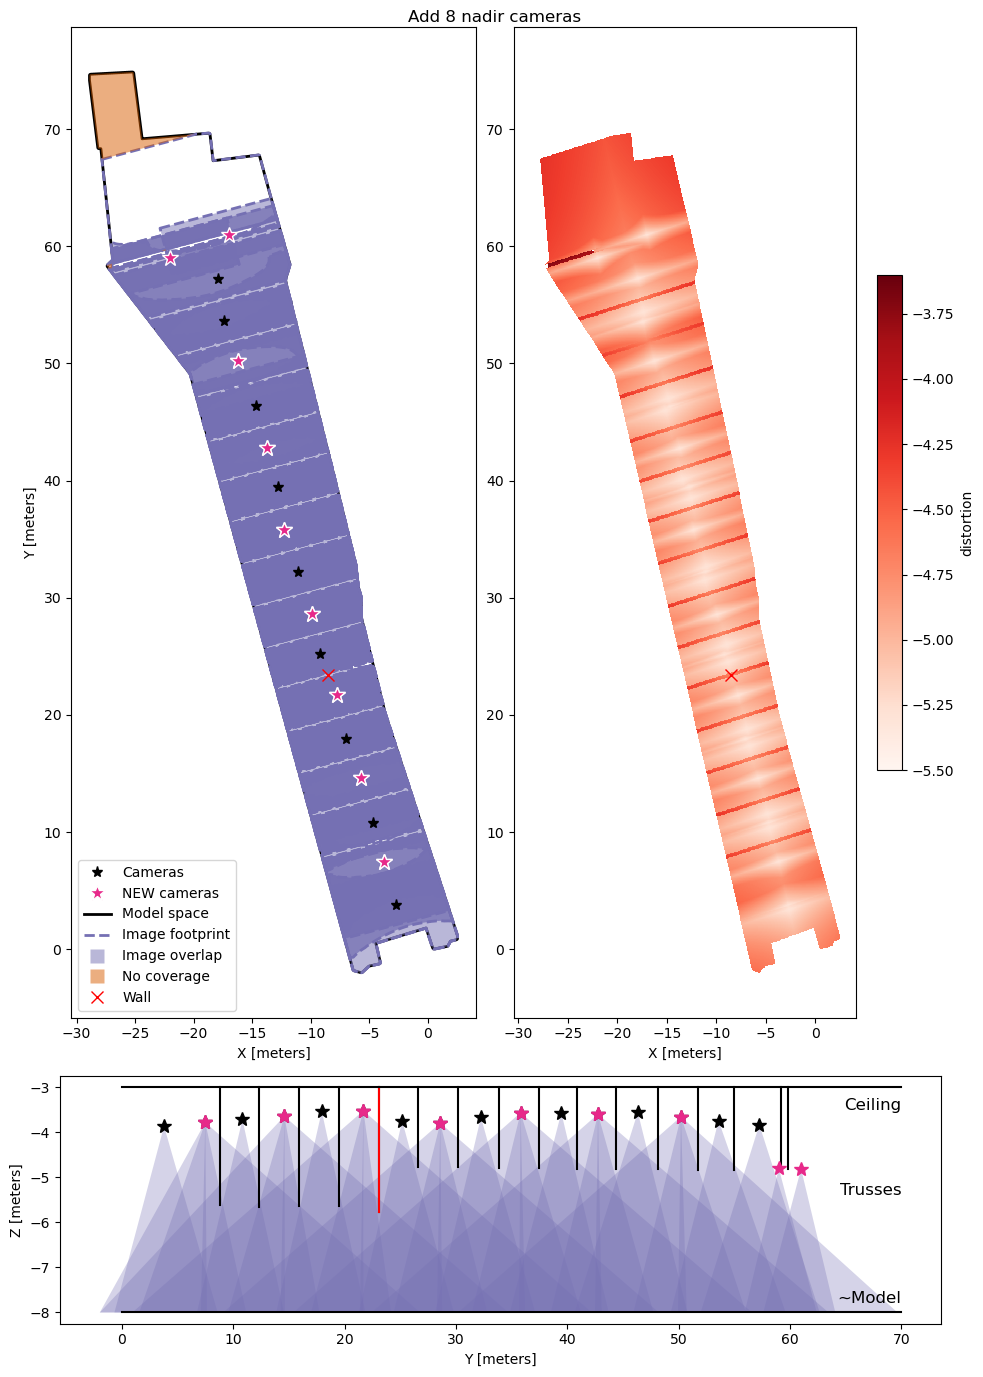

Figure saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_16_angled_cameras.png
New camera specs saved to file: /Users/rdcrlrka/Research/Soo_locks/inputs/../add_cameras/add_16_angled_cams_specs.csv


In [98]:
new_coords = np.array([
    (-22, 59, rh.loc[rh['Label']=='North 1', 'Z-Value - 15cm'].values[0]),
    (-17, 61, rh.loc[rh['Label']=='North 2', 'Z-Value - 15cm'].values[0]),
    cams.loc[cams['channel']=='ch02', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch02', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch04', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch04', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch06', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch06', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch08', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch08', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch10', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch10', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch12', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch12', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch14', ['X', 'Y', 'Z']].values[0],
    cams.loc[cams['channel']=='ch14', ['X', 'Y', 'Z']].values[0],
])

new_rolls = np.concatenate([
    np.zeros(2),                            # northern-most cams
    45* np.array([-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1])     # rest of the cams
])

(cams_new, cams_new_full, bounds_new_gdf, 
 bounds_new_full_gdf, overlap_new_gdf, 
 no_coverage_new_full) = calculate_specs_from_new_coords(
     new_coords = new_coords,
     new_rolls = new_rolls,
     cams = cams,
     bounds = bounds_gdf,
     model_space = model_space_gdf,
     fov_h = fov_h,
     fov_v = fov_v,
     trusses_gdf = trusses_gdf
 )

# Calculate map of relative distortion
distortion_map = create_distortion_map(
    cams_gdf = cams_new_full,
    footprints_gdf = bounds_new_full_gdf,
    yaw_series = 15 * np.ones(len(cams_new_full)),
    roll_series = np.concatenate([np.zeros(len(cams)), new_rolls]), 
    pitch_series = np.zeros(len(cams_new_full)),
    fov_h_deg = fov_h,
    fov_v_deg = fov_v,
    model_space = model_space_gdf
)

# Plot results
gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[4,1])
fig = plt.figure(figsize=(10,14))
ax = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,:])
    ]
# plot model coverage
plot_model_coverage(ax[0], model_space_gdf, bounds_new_full_gdf, overlap_new_gdf, cams_new_full, no_coverage_new_full)

# plot vertical view
plot_vertical_view(ax[2], trusses_gdf, cams, cams_new = cams_new, bounds = bounds_gdf, bounds_new = bounds_new_gdf)

# plot relative distortion
distortion_map.plot(ax=ax[1], cmap='Reds', vmin=-5.5, vmax=-3.6, cbar_kwargs={'shrink': 0.5})
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlabel('X [meters]')
ax[1].set_ylabel('')
ax[1].set_title('')
# plot the wall location
xcoord, ycoord = get_coords_between_cams('ch06', 'ch07')
for axis in ax[0:2]:
    axis.plot(xcoord, ycoord, 'xr', markersize=8, linewidth=2, label='Wall')
ax[0].legend(loc='lower left')

fig.suptitle('Add 8 nadir cameras')
fig.tight_layout()
plt.show()

# Save figure
fig_file = os.path.join(output_folder, 'add_16_angled_cameras.png')
fig.savefig(fig_file, dpi=300, bbox_inches='tight')
print('Figure saved to file:', fig_file)

# Save new specs
out_file = os.path.join(output_folder, 'add_16_angled_cams_specs.csv')
save_specs_los(bounds_new_gdf, cams_new, out_file, fov_h=fov_h, fov_v=fov_v)